In [0]:
# Import libraries for ML.
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, MaxPooling2D, TimeDistributed, LeakyReLU, concatenate, Permute
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.losses import mean_squared_error, logcosh
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import os
import random
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [0]:
# Mount Google Drive to import dataset.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Set data constants for the tensor of dimension (N,T,S,S,K).
N = 42      # Samples (Region, City, County, etc.) in Dataset
T = 15      # Time Series Duration/Slices of Heatmaps
S = 121     # Dimension/Size of Spatial Window of Heatmap
K = 31      # Number of Features in the Dataset (i.e. Price, Size, etc.)

In [0]:
# PART I - Import and construct machine learning dataset.
path = "/content/drive/My Drive/colab_data_proc"
# Import and collect machine learning data to NumPy arrays.
data_input = np.zeros((N,T,S,S,K), dtype=np.single)
data_output = np.zeros((N,S,S), dtype=np.single)
i, j = 0, 0
for file in sorted(os.listdir(path)):
  print(file)
  # Extract input and output data. Reduce data precision to save memory.
  if file.endswith("_input.npy"):
    data_input[i] = np.load(path + '/' + file).astype(np.single)
    i += 1
  elif file.endswith("_output.npy"):
    # Dispose of remainder data.
    data_output[j] = np.load(path + '/' + file).astype(np.single)[0]
    j += 1

# Separate training and test data via index mask to save memory via Python referencing.
# Randomly choose 6 sample regions for validation/testing. Other samples are for training.
rand_idx = random.sample(range(N), 6)
train_idx = sorted(list(set(range(N)) - set(rand_idx)))
val_idx = sorted(rand_idx[:4])
test_idx = sorted(rand_idx[4:])

# # Alternative: Fix Los Angeles County as test set for time-series display in publication.
# rand_idx = random.sample(set(range(N)) - set([3]), 3)
# train_idx = sorted(list(set(range(N)) - set(rand_idx + [3])))
# val_idx = sorted(rand_idx)
# test_idx = [3]
# # Export test data time-series as .csv. Isolate property value for heatmap. Los Angeles has index 3 in dataset.
# la = "/content/drive/My Drive/pred_results/pred_heatmap_LA/"
# for ts in range(T):
#   np.savetxt(la + "la_heatmap_ts_{}.csv".format(ts+1), data_input[3, ts, :, :, 0], delimiter=",")

# Print training, validation, and test indices. (Compare with dataset for regions.)
print(train_idx)
print(val_idx)
print(test_idx)

# Extract data as .npy file to avoid import process and rename data. Print data dimensions.
np.save("/content/drive/My Drive/colab_train_data/x_train_ts_heatmap", data_input[train_idx])
print("Training Input Shape: ", data_input[train_idx].shape)
np.save("/content/drive/My Drive/colab_train_data/y_train_ts_heatmap", data_output[train_idx])
print("Training Output Shape: ", data_output[train_idx].shape)
np.save("/content/drive/My Drive/colab_train_data/x_val_ts_heatmap", data_input[val_idx])
print("Validation Input Shape: ", data_input[val_idx].shape)
np.save("/content/drive/My Drive/colab_train_data/y_val_ts_heatmap", data_output[val_idx])
print("Validation Output Shape: ", data_output[val_idx].shape)
np.save("/content/drive/My Drive/colab_train_data/x_test_ts_heatmap", data_input[test_idx])
print("Test Input Shape: ", data_input[test_idx].shape)
np.save("/content/drive/My Drive/colab_train_data/y_test_ts_heatmap", data_output[test_idx])
print("Test Output Shape: ", data_output[test_idx].shape)

# ------------------------------------------------------ #

# PART II - Import previously saved data. 
# x_ has input dimension (:,T,S,S,K) and y_ has output dimension (:,S,S).
path = "/content/drive/My Drive/colab_train_data"
x_train = np.load(path + '/' + "x_train_ts_heatmap.npy")
y_train = np.load(path + '/' + "y_train_ts_heatmap.npy")
x_val = np.load(path + '/' + "x_val_ts_heatmap.npy")
y_val = np.load(path + '/' + "y_val_ts_heatmap.npy")
x_test = np.load(path + '/' + "x_test_ts_heatmap.npy")
y_test = np.load(path + '/' + "y_test_ts_heatmap.npy")

# Logarithmic and shift normalization due to incredibly diverse variance of (non-negative) data.
eps = 1e-3
x_train[:, :, :, :, [0,4,5,6,7,8,9]] = np.log(x_train[:, :, :, :, [0,4,5,6,7,8,9]] + eps + 1)
x_train[:, :, :, :, 2] -= 2000
y_train = np.log(y_train + eps + 1)
x_val[:, :, :, :, [0,4,5,6,7,8,9]] = np.log(x_val[:, :, :, :, [0,4,5,6,7,8,9]] + eps + 1)
x_val[:, :, :, :, 2] -= 2000
y_val = np.log(y_val + eps + 1)
x_test[:, :, :, :, [0,4,5,6,7,8,9]] = np.log(x_test[:, :, :, :, [0,4,5,6,7,8,9]] + eps + 1)
x_test[:, :, :, :, 2] -= 2000

# [DEBUG]
# print(np.unravel_index(np.argmax(x_train, axis=None), x_train.shape))
# print(np.max(x_train))
# print(x_train[0, 0, 7, 0, :])

# Print training and test data dimensions.
print("Training Input Shape: ", x_train.shape)
print("Training Output Shape: ", y_train.shape)
print("Validation Input Shape: ", x_val.shape)
print("Validation Output Shape: ", y_val.shape)
print("Test Input Shape: ", x_test.shape)
print("Test Output Shape: ", y_test.shape)

Training Input Shape:  (38, 15, 121, 121, 31)
Training Output Shape:  (38, 121, 121)
Validation Input Shape:  (3, 15, 121, 121, 31)
Validation Output Shape:  (3, 121, 121)
Test Input Shape:  (1, 15, 121, 121, 31)
Test Output Shape:  (1, 121, 121)


In [0]:
"""
[Elementary Convolutional Inception Module]
Apply supporting convolutional inception filters to learn spatial features 
from the weighted heatmap prior to application of LSTM.
Utilized to construct an inception-convolutional LSTM.
"""
# Initialize and reshape input. Assume feature maps are time-invariant. 
input = Input(shape=(S, S, K))

# Lightweight Convolutional Inception Module (5-Path Filter) for Feature Mixing
t1 = Conv2D(32, (1, 1), padding='same', data_format='channels_last')(input)
t2 = Conv2D(16, (3, 3), padding='same', data_format='channels_last')(input)
t3 = Conv2D(8, (7, 7), padding='same', data_format='channels_last')(input)
t4 = Conv2D(4, (11, 11), padding='same', data_format='channels_last')(input)
t5 = MaxPooling2D(pool_size=(3,3), strides=(1,1), 
                  padding='same', data_format='channels_last')(input)

# Compute output.
output = concatenate([t1, t2, t3, t4, t5])

# Construct layer/model.
conv_incptn = Model(inputs=input, outputs=output)
"""
[Multi-Layer Inception-Convolutional LSTM Architecture for Housing Index Forecasting]
Apply space-time convolutional LSTM layers via ConvLSTM2D.
Input (N,T,S,S,K) -> [Incptn-Conv -> Conv-LSTM -> Batch Normalization] x 4
                  -> Conv2D -> LeakyReLU -> Output (S,S) is a 2-D heatmap.
(Derivation Source: https://arxiv.org/pdf/1909.05622.pdf)
"""
# Intialize a sequential model.
incptn_conv_lstm = Sequential()

# Insert a series of Conv-LSTM and Batch Normalization Layers.
incptn_conv_lstm.add(TimeDistributed(conv_incptn, input_shape=(T, S, S, K)))
incptn_conv_lstm.add(ConvLSTM2D(filters=K, kernel_size=(3, 3),
                          padding='same', data_format='channels_last', 
                          return_sequences=True))
incptn_conv_lstm.add(TimeDistributed(BatchNormalization()))
incptn_conv_lstm.add(TimeDistributed(conv_incptn))
incptn_conv_lstm.add(ConvLSTM2D(filters=K, kernel_size=(3, 3),
                          padding='same', data_format='channels_last', 
                          return_sequences=True))
incptn_conv_lstm.add(TimeDistributed(BatchNormalization()))
incptn_conv_lstm.add(TimeDistributed(conv_incptn))
incptn_conv_lstm.add(ConvLSTM2D(filters=K, kernel_size=(3, 3),
                          padding='same', data_format='channels_last', 
                          return_sequences=True))
incptn_conv_lstm.add(TimeDistributed(BatchNormalization()))
incptn_conv_lstm.add(TimeDistributed(conv_incptn))
incptn_conv_lstm.add(ConvLSTM2D(filters=K, kernel_size=(3, 3),
                          padding='same', data_format='channels_last', 
                          return_sequences=False))
incptn_conv_lstm.add(TimeDistributed(BatchNormalization()))

# Conv2D layer to collapse filters.
incptn_conv_lstm.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', data_format='channels_last'))

# Reshape to heatmap.
incptn_conv_lstm.add(Reshape((S, S)))

# Weak LeakyReLU to avoid neuron death and approximate ReLU.
incptn_conv_lstm.add(LeakyReLU(alpha=0.1))

# Compile the model. Nesterov SGD with thresholded gradient and MSE Loss.
incptn_conv_lstm.compile(optimizer=SGD(lr=2e-3, momentum=0.2, nesterov=True, clipnorm=0.25), loss=mean_squared_error)

In [0]:
incptn_conv_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 121, 121, 91)  32672     
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 15, 121, 121, 31)  136276    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 121, 121, 91)  32672     
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 15, 121, 121, 31)  136276    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 121, 121, 91) 

In [0]:
# Set model checkpoint to save the trained model.
cp_path = "/content/drive/My Drive/trained_models/incptn_conv_lstm"
cp_callback = ModelCheckpoint(filepath=cp_path, monitor='val_loss', save_weights_only=False, save_best_only=True, mode='min', period=1)

In [0]:
# Load pre-trained model. (Overwrites un-trained model!)
incptn_conv_lstm = load_model(cp_path)
incptn_conv_lstm.summary()

In [0]:
# Train the Hybrid Inceptive-Conv-LSTM Model on the Time-Series Heatmap Data.
num_epoch = 30
model_stats = incptn_conv_lstm.fit(x=x_train, y=y_train, batch_size=int(N/4), epochs=num_epoch, validation_data=(x_val, y_val), callbacks=[cp_callback])

Train on 38 samples, validate on 3 samples
Epoch 1/30
38/38 [==============================] - 305s 8s/step - loss: 7.8075 - val_loss: 8.9248
Epoch 2/30
38/38 [==============================] - 259s 7s/step - loss: 7.7507 - val_loss: 5.1664
Epoch 3/30
38/38 [==============================] - 251s 7s/step - loss: 7.6286 - val_loss: 5.1781
Epoch 4/30
38/38 [==============================] - 250s 7s/step - loss: 7.5886 - val_loss: 5.1990
Epoch 5/30
38/38 [==============================] - 273s 7s/step - loss: 7.5531 - val_loss: 5.6312
Epoch 6/30
38/38 [==============================] - 275s 7s/step - loss: 7.5280 - val_loss: 5.2536
Epoch 7/30
38/38 [==============================] - 262s 7s/step - loss: 7.6215 - val_loss: 5.1172
Epoch 8/30
38/38 [==============================] - 280s 7s/step - loss: 7.4558 - val_loss: 5.0562
Epoch 9/30
38/38 [==============================] - 297s 8s/step - loss: 7.4393 - val_loss: 5.0163
Epoch 10/30
38/38 [==============================] - 263s 7s/step 

In [0]:
# Part I - Cache loss data. (Initialize loss cache to track model training.)
train_loss = model_stats.history['loss']
val_loss = model_stats.history['val_loss']

In [0]:
# Part II - Append loss data to cache. (To collect loss data through multiple training sessions.)
train_loss = train_loss + model_stats.history['loss']
val_loss = val_loss + model_stats.history['val_loss']

In [0]:
# Part III - Export loss data for analysis or preservation.
np.save("/content/drive/My Drive/pred_results/train_loss", train_loss)
np.save("/content/drive/My Drive/pred_results/val_loss", val_loss)

In [0]:
# Part IV - Load loss statistics.
train_loss = np.load("/content/drive/My Drive/pred_results/train_loss")
val_loss = np.load("/content/drive/My Drive/pred_results/val_loss")

Text(0, 0.5, 'Mean-Squared Error Validation Loss')

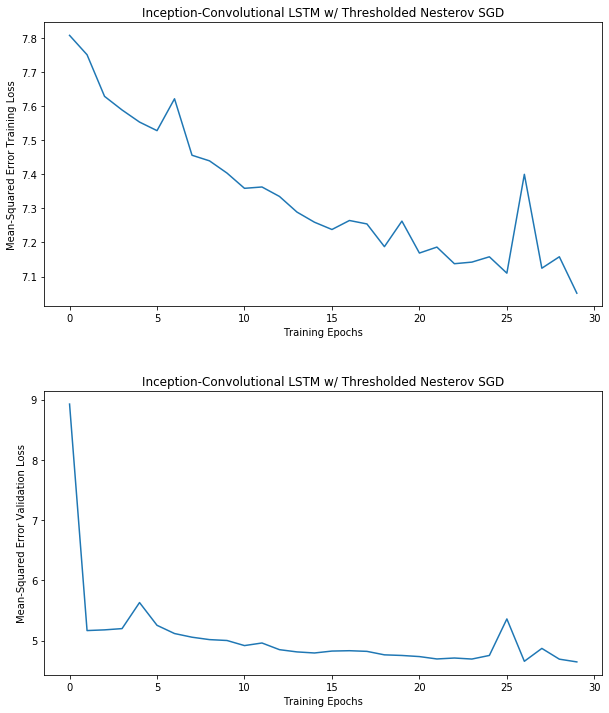

In [0]:
# Output loss statistics. Plot training and validation loss over epochs.
plt.rcParams['figure.figsize'] = (10.0, 12.0) # set default size of plots
plt.subplots_adjust(hspace = 0.3)
# Training Loss
plt.subplot(2,1,1)
plt.plot(range(len(train_loss)), train_loss)
plt.title('Inception-Convolutional LSTM w/ Thresholded Nesterov SGD')
plt.xlabel('Training Epochs')
plt.ylabel('Mean-Squared Error Training Loss')
# Validation Loss
plt.subplot(2,1,2)
plt.plot(range(len(val_loss)), val_loss)
plt.title('Inception-Convolutional LSTM w/ Thresholded Nesterov SGD')
plt.xlabel('Training Epochs')
plt.ylabel('Mean-Squared Error Validation Loss')

In [0]:
# Save model manually. (Deletes the optimal model! Sometimes desirable if the model is close to prior optimal, but needs more training without overwriting descent progress.)
incptn_conv_lstm.save(cp_path)

In [0]:
# Load optimal pre-trained model.
incptn_conv_lstm_opt = load_model(cp_path)
incptn_conv_lstm_opt.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 15, 121, 121, 91)  32672     
_________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D) (None, 15, 121, 121, 31)  136276    
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 121, 121, 91)  32672     
_________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D) (None, 15, 121, 121, 31)  136276    
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 15, 121, 121, 91) 

In [0]:
# Test the trained model. Print test loss for all test sets.
pred = incptn_conv_lstm_opt.predict(x_test)
print("Average Test Loss: ", incptn_conv_lstm_opt.evaluate(x_test, np.log(y_test + eps + 1)))

# Rectify and un-normalize the output data.
pred = np.exp(pred) - eps - 1
pred[pred < eps] = 0

# Export the heatmaps.
path = "/content/drive/My Drive/pred_results"
for ts in range(len(y_test)):
  np.savetxt(path + '/' + "pred_heatmap_{}.csv".format(ts), pred[ts], delimiter=",")
  np.savetxt(path + '/' + "test_heatmap_{}.csv".format(ts), y_test[ts], delimiter=",")

1/1 [==============================] - 3s 3s/step
Average Test Loss:  9.647385597229004


In [0]:
"""
[Deep / Wide Convolutional Inception Module]
Apply supporting convolutional inception filters to learn spatial features 
from the weighted heatmap. Derivation of GoogleNet Inception Module.
"""
# Initialize and reshape input. Assume feature maps are time-invariant. 
input = Input(shape=(S, S, K))

# Lightweight Convolutional Inception Module (5-Path Filter) for Feature Mixing
t1 = Conv2D(64, (1, 1), padding='same', data_format='channels_last')(input)

t2 = Conv2D(32, (1, 1), padding='same', data_format='channels_last')(input)
t2 = Conv2D(32, (3, 3), padding='same', data_format='channels_last')(t2)

t3 = Conv2D(32, (1, 1), padding='same', data_format='channels_last')(input)
t3 = Conv2D(16, (5, 5), padding='same', data_format='channels_last')(t3)

t4 = Conv2D(32, (1, 1), padding='same', data_format='channels_last')(input)
t4 = Conv2D(8, (11, 11), padding='same', data_format='channels_last')(t4)

t5 = Conv2D(16, (1, 1), padding='same', data_format='channels_last')(input)
t5 = Conv2D(2, (47, 47), padding='same', data_format='channels_last')(t5)

t6 = MaxPooling2D(pool_size=(3,3), strides=(1,1), 
                  padding='same', data_format='channels_last')(input)
t6 = Conv2D(8, (1, 1), padding='same', data_format='channels_last')(t6)

# Compute output.
output = concatenate([t1, t2, t3, t4, t5, t6])

# Construct layer/model.
deep_conv_incptn = Model(inputs=input, outputs=output)

"""
[Deep Spatio-Temporal Convolutional Neural Net for Imitation Learning]
Reinforcement/Imitation Learning with time-distributed inception CNN to compare with the inception-convolutional LSTM.

"""
# Initialize Sequential().
td_cnn = Sequential()

# Insert a deep, time-distributed Inception-CNN.
td_cnn.add(TimeDistributed(deep_conv_incptn, input_shape=(T, S, S, K)))
td_cnn.add(TimeDistributed(BatchNormalization()))

# Mix and compress features to 1.
td_cnn.add(TimeDistributed(Conv2D(filters=K, kernel_size=(3, 3), padding='same', data_format='channels_last')))
td_cnn.add(TimeDistributed(BatchNormalization()))
td_cnn.add(TimeDistributed(Conv2D(filters=K, kernel_size=(3, 3), padding='same', data_format='channels_last')))
td_cnn.add(TimeDistributed(BatchNormalization()))

# Apply Conv3D layer(s) to mix spatio-temporal heatmap time-slices for Transitional Imitation Learning.
# Layers sufficient for temporal receptive field > T.
td_cnn.add(Conv3D(filters=T, kernel_size=(3, 3, 3), padding='same', data_format='channels_last'))
td_cnn.add(TimeDistributed(BatchNormalization()))
td_cnn.add(Conv3D(filters=5, kernel_size=(3, 3, 3), padding='same', data_format='channels_last'))
td_cnn.add(TimeDistributed(BatchNormalization()))
td_cnn.add(Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same', data_format='channels_last'))
td_cnn.add(TimeDistributed(BatchNormalization()))
td_cnn.add(Reshape((T, S, S)))

# Collapse time-dimension. Re-shape to heatmap.
td_cnn.add(Permute((2, 3, 1)))
td_cnn.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', data_format='channels_last'))
td_cnn.add(Reshape((S, S)))

# Weak LeakyReLU to avoid neuron death and approximate ReLU.
td_cnn.add(LeakyReLU(alpha=0.1))

# Compile the model. Nesterov SGD with thresholded gradient and MSE Loss.
td_cnn.compile(optimizer=SGD(lr=1e-3, momentum=0.2, nesterov=True), loss=mean_squared_error)

In [0]:
td_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 15, 121, 121, 130) 129626    
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 121, 121, 130) 520       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 15, 121, 121, 31)  36301     
_________________________________________________________________
time_distributed_44 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 15, 121, 121, 1)   280       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 15, 121, 121, 1)   4         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 121, 121, 15) 

In [0]:
# Set model checkpoint to save the trained model.
cp_path_alt = "/content/drive/My Drive/trained_models/incptn_conv_td"
cp_callback_alt = ModelCheckpoint(filepath=cp_path_alt, monitor='val_loss', save_weights_only=False, save_best_only=True, mode='min', period=1)

In [0]:
# Load pre-trained model. (Overwrites un-trained model!)
td_cnn = load_model(cp_path_alt)
td_cnn.summary()

In [0]:
# Train the Hybrid Inceptive-Conv-LSTM Model on the Time-Series Heatmap Data.
num_epoch_alt = 30
model_stats_alt = td_cnn.fit(x=x_train, y=y_train, batch_size=int(N/4), epochs=num_epoch_alt, validation_data=(x_val, y_val), callbacks=[cp_callback_alt])

Train on 38 samples, validate on 3 samples
Epoch 1/30
38/38 [==============================] - 362s 10s/step - loss: 7.3063 - val_loss: 4.3624
Epoch 2/30
38/38 [==============================] - 339s 9s/step - loss: 6.7507 - val_loss: 3.9257
Epoch 3/30
38/38 [==============================] - 338s 9s/step - loss: 6.4083 - val_loss: 3.7944
Epoch 4/30
38/38 [==============================] - 344s 9s/step - loss: 6.3291 - val_loss: 3.6859
Epoch 5/30
38/38 [==============================] - 344s 9s/step - loss: 6.2892 - val_loss: 3.6456
Epoch 6/30
38/38 [==============================] - 340s 9s/step - loss: 6.1995 - val_loss: 3.6152
Epoch 7/30
38/38 [==============================] - 346s 9s/step - loss: 6.2348 - val_loss: 3.5714
Epoch 8/30
38/38 [==============================] - 338s 9s/step - loss: 6.1698 - val_loss: 3.5783
Epoch 9/30
38/38 [==============================] - 340s 9s/step - loss: 6.2084 - val_loss: 3.5259
Epoch 10/30
38/38 [==============================] - 345s 9s/step

In [0]:
# Part I - Cache loss data. (Initialize loss cache to track model training.)
train_loss_alt = model_stats_alt.history['loss']
val_loss_alt = model_stats_alt.history['val_loss']

In [0]:
# Part II - Append loss data to cache. (To collect loss data through multiple training sessions.)
train_loss_alt = train_loss_alt + model_stats_alt.history['loss']
val_loss_alt = val_loss_alt + model_stats_alt.history['val_loss']

In [0]:
# Part III - Export loss data for analysis or preservation.
np.save("/content/drive/My Drive/pred_results/train_loss_alt", train_loss_alt)
np.save("/content/drive/My Drive/pred_results/val_loss_alt", val_loss_alt)

In [0]:
# Part IV - Load loss statistics.
train_loss_alt = np.load("/content/drive/My Drive/pred_results/train_loss_alt.npy")
val_loss_alt = np.load("/content/drive/My Drive/pred_results/val_loss_alt.npy")

Text(0, 0.5, 'Mean-Squared Error Validation Loss')

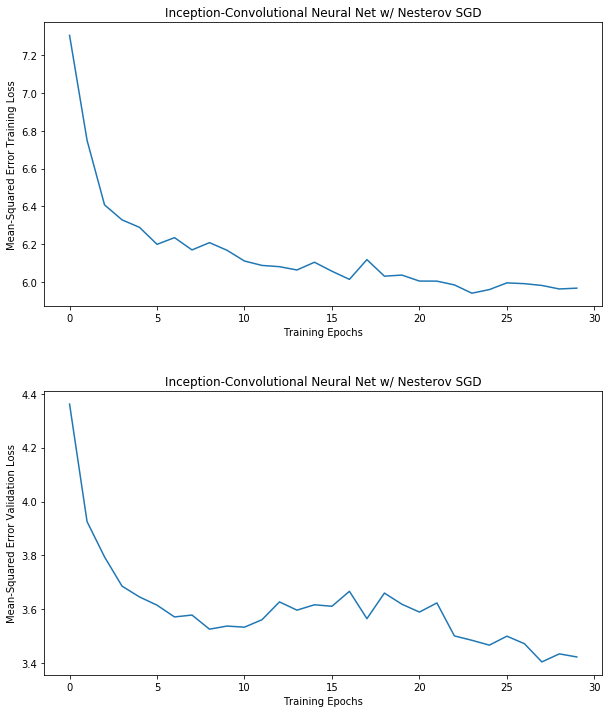

In [0]:
# Output loss statistics. Plot training and validation loss over epochs.
plt.rcParams['figure.figsize'] = (10.0, 12.0) # set default size of plots
plt.subplots_adjust(hspace = 0.3)
# Training Loss
plt.subplot(2,1,1)
plt.plot(range(len(train_loss_alt)), train_loss_alt)
plt.title('Inception-Convolutional Neural Net w/ Nesterov SGD')
plt.xlabel('Training Epochs')
plt.ylabel('Mean-Squared Error Training Loss')
# Validation Loss
plt.subplot(2,1,2)
plt.plot(range(len(val_loss_alt)), val_loss_alt)
plt.title('Inception-Convolutional Neural Net w/ Nesterov SGD')
plt.xlabel('Training Epochs')
plt.ylabel('Mean-Squared Error Validation Loss')

In [0]:
# Save model manually. (Deletes the optimal model! Sometimes desirable if the model is close to prior optimal, but needs more training without overwriting descent progress.)
td_cnn.save(cp_path_alt)

In [0]:
# Load optimal pre-trained model.
td_cnn_opt = load_model(cp_path_alt)
td_cnn_opt.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 15, 121, 121, 130) 129626    
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 121, 121, 130) 520       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 15, 121, 121, 31)  36301     
_________________________________________________________________
time_distributed_44 (TimeDis (None, 15, 121, 121, 31)  124       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 15, 121, 121, 1)   280       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 15, 121, 121, 1)   4         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 121, 121, 15) 

In [0]:
# Test the trained model. Print test loss for all test sets.
pred_alt = td_cnn_opt.predict(x_test)
print("Average Test Loss: ", td_cnn_opt.evaluate(x_test, np.log(y_test + eps + 1)))

# Rectify and un-normalize the output data.
pred_alt = np.exp(pred_alt) - eps - 1
pred_alt[pred_alt < eps] = 0

# Export the heatmaps.
path = "/content/drive/My Drive/pred_results"
for ts in range(len(y_test)):
  np.savetxt(path + '/' + "pred_heatmap_alt_{}.csv".format(ts), pred_alt[ts], delimiter=",")
  np.savetxt(path + '/' + "test_heatmap_alt_{}.csv".format(ts), y_test[ts], delimiter=",")

1/1 [==============================] - 3s 3s/step
Average Test Loss:  13.345495223999023
